# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]
 # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    output_frame["mj1-mj2"] = output_frame["mj1"] -output_frame["mj2"]

    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 2048# Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00001
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")
df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
min(df["tau2j2"])

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


1e-06

In [6]:
df = load_data("herwig")
df.dropna(inplace = True)
#df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)

df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

In [7]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,...,ej1,ej2,ejj,pjj,mjj,tau21j1,tau32j1,tau21j2,tau32j2,mj1-mj2
0,-606.640015,136.223999,-2463.290039,115.829002,41.708900,19.615000,16.282600,1410.239990,-311.454010,516.468018,...,2543.183594,1537.945679,4081.129395,840.942322,3993.548828,0.470283,0.830110,0.614313,0.647716,2.881004
1,1075.790039,560.247986,-473.667999,253.820999,98.636002,46.423801,37.188900,-785.905029,-476.933990,-1670.449951,...,1326.645630,1906.993530,3233.639160,312.914948,3218.463379,0.470658,0.801074,0.345675,0.681456,220.523193
2,-963.197998,-802.231995,-255.048004,369.252991,203.923996,32.369499,22.955299,1066.229980,662.479980,-1211.520020,...,1331.436768,1748.691895,3080.128662,222.883026,3072.053955,0.158733,0.709165,0.349252,0.687567,249.183990
3,-914.739014,-1285.349976,-390.425995,420.726013,183.169006,29.843300,24.244101,910.085022,1286.180054,228.893997,...,1678.783691,1593.454956,3272.238770,4.799760,3272.235107,0.162928,0.812380,0.515532,0.832525,355.978119
4,1178.770020,-442.437988,-816.497009,429.519989,272.453003,162.826004,113.084999,-945.479004,402.459015,-412.460999,...,1560.898804,1110.571655,2671.470459,240.044449,2660.664062,0.597630,0.694514,0.720654,0.639655,343.837708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999419,-710.262024,-1026.920044,-1307.729980,796.106995,744.283020,368.661987,210.828003,692.814026,976.697998,-41.325802,...,1975.596313,1198.612427,3174.208740,73.136452,3173.365967,0.495325,0.571873,0.770408,0.594857,763.957764
999420,-268.907990,1307.540039,1420.180054,333.614014,240.792007,171.697006,130.660995,155.938995,-1274.060059,-1473.140015,...,1977.418091,1957.884277,3935.302490,122.490051,3933.395508,0.713051,0.760998,0.298112,0.729554,208.620010
999421,314.462006,1388.619995,-158.914001,420.259003,295.635986,57.412300,44.277100,65.702904,-1444.400024,-1056.260010,...,1492.991333,1792.290039,3285.281494,388.263031,3262.257812,0.194199,0.771213,0.600804,0.573244,342.734100
999422,-133.639999,1522.699951,-229.511993,632.781006,504.207001,105.698997,48.149700,29.203501,-1470.739990,-839.638977,...,1670.198242,1704.347900,3374.546143,127.697525,3372.129150,0.209634,0.455536,0.705832,0.759785,443.363007


In [8]:
np.any(np.isnan(df))

False

In [9]:
df = df.drop(df.columns[[0,1,2,4,5,6,7,8,9,11,12,13,14,15,16,17,20,22]], axis=1)

In [10]:
df

,mj1,mj2,mjj,tau21j1,tau21j2,mj1-mj2
0,115.829002,112.947998,3993.548828,0.470283,0.614313,2.881004
1,253.820999,33.297798,3218.463379,0.470658,0.345675,220.523193
2,369.252991,120.069000,3072.053955,0.158733,0.349252,249.183990
3,420.726013,64.747902,3272.235107,0.162928,0.515532,355.978119
4,429.519989,85.682297,2660.664062,0.597630,0.720654,343.837708
...,...,...,...,...,...,...
999419,796.106995,32.149200,3173.365967,0.495325,0.770408,763.957764
999420,333.614014,124.994003,3933.395508,0.713051,0.298112,208.620010
999421,420.259003,77.524902,3262.257812,0.194199,0.600804,342.734100
999422,632.781006,189.417999,3372.129150,0.209634,0.705832,443.363007


In [11]:
# Normalize all inputs between -1 and 1

train_features = ["mj1-mj2"]
scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))
gc.collect()

Dataset consists of 366 batches of 2048 samples each, total 749568 samples
Testset consists of 122 batches of 2048 samples each, total 249856 samples


20

In [12]:
X_train

array([[-0.8420107 ],
       [-0.29810023],
       [-0.9210304 ],
       ...,
       [-0.97977406],
       [-0.73957765],
       [-0.83700246]], dtype=float32)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [14]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [15]:
generator = make_generator_model()

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [17]:
discriminator = make_discriminator_model()

In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [20]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [21]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [22]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [23]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [24]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [25]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [26]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [27]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [28]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [29]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.ylabel("Normalized to Unity")
    
    plt.hist(df['mj1-mj2'], bins = 50, range = (0, 800), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 50, range = (0, 800), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()
    

In [30]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [31]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [32]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [33]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    
    print_losses = ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 100 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0


    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)

            
    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging

    if print_losses:
      print()

      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)

      graph_genloss()
      graph_discloss()


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

  1%|▊                                                                             | 10/1000 [02:21<3:53:44, 14.17s/it]


Epoch 10:

Generator training loss: -1.1717549764393458
Discriminator training loss: -0.124781137472782

Generator validation loss: -1.228417580244971
Discriminator validation loss: -0.09906512114112495


  2%|█▌                                                                            | 20/1000 [04:43<3:49:30, 14.05s/it]


Epoch 20:

Generator training loss: -1.4248099786336306
Discriminator training loss: 0.1461802839988568

Generator validation loss: -1.6260676608710993
Discriminator validation loss: 0.15965425821601367


  3%|██▎                                                                           | 30/1000 [07:03<3:46:28, 14.01s/it]


Epoch 30:

Generator training loss: -1.7955880236755954
Discriminator training loss: 0.1723153542096172

Generator validation loss: -1.9378662314571318
Discriminator validation loss: 0.1923549888563938


  4%|███                                                                           | 40/1000 [09:25<3:51:35, 14.47s/it]


Epoch 40:

Generator training loss: -1.6627844510182657
Discriminator training loss: 0.147884043497466

Generator validation loss: -1.9775843405332723
Discriminator validation loss: 0.19958304381761394


  5%|███▉                                                                          | 50/1000 [11:44<3:41:05, 13.96s/it]


Epoch 50:

Generator training loss: -1.3327815969133638
Discriminator training loss: 0.09212170210387048

Generator validation loss: -1.9584318291945535
Discriminator validation loss: 0.2003941344188862


  6%|████▋                                                                         | 60/1000 [14:03<3:37:59, 13.91s/it]


Epoch 60:

Generator training loss: -0.9347914590861628
Discriminator training loss: 0.00829271663265313

Generator validation loss: -1.986728913471347
Discriminator validation loss: 0.1429284819569744


  7%|█████▍                                                                        | 70/1000 [16:23<3:36:32, 13.97s/it]


Epoch 70:

Generator training loss: -1.1436409399809082
Discriminator training loss: -0.00021519328168975198

Generator validation loss: -2.0531661862232644
Discriminator validation loss: 0.007901396487169655


  8%|██████▏                                                                       | 80/1000 [18:46<3:42:05, 14.48s/it]


Epoch 80:

Generator training loss: -1.2878548577835
Discriminator training loss: 0.0006786334700749242

Generator validation loss: -2.1006273812935
Discriminator validation loss: 0.0020598107461648665


  9%|███████                                                                       | 90/1000 [21:09<3:36:34, 14.28s/it]


Epoch 90:

Generator training loss: -1.3047152063885674
Discriminator training loss: 0.0008290598207018835

Generator validation loss: -2.181146957835213
Discriminator validation loss: 0.005486281272407991


 10%|███████▋                                                                      | 99/1000 [23:16<3:32:33, 14.15s/it]


Epoch 100:

Generator training loss: -1.236739931862211
Discriminator training loss: 0.002008606600768578

Generator validation loss: -2.203064148543311
Discriminator validation loss: 0.0011159791587279407

Epoch 100:


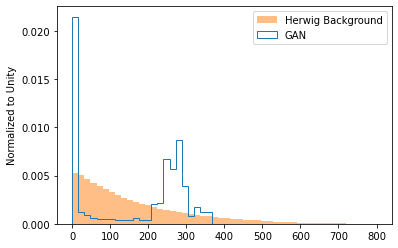

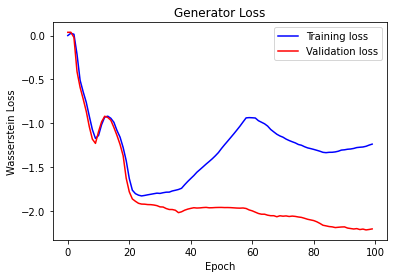

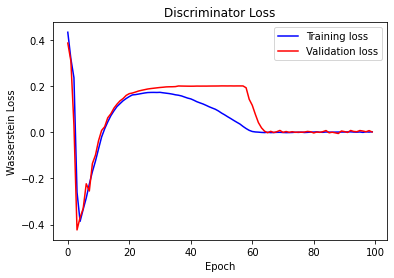

 11%|████████▍                                                                    | 110/1000 [25:52<3:28:53, 14.08s/it]


Epoch 110:

Generator training loss: -1.166006741953678
Discriminator training loss: 0.0003925841665368154

Generator validation loss: -2.179032341378634
Discriminator validation loss: 0.005250906192918964


 12%|█████████▏                                                                   | 120/1000 [28:15<3:26:01, 14.05s/it]


Epoch 120:

Generator training loss: -1.1349528220181908
Discriminator training loss: -0.00044238954888881933

Generator validation loss: -2.1638552693069957
Discriminator validation loss: 0.007355897304075713


 13%|██████████                                                                   | 130/1000 [30:36<3:25:45, 14.19s/it]


Epoch 130:

Generator training loss: -1.1125523776955943
Discriminator training loss: 0.0011283969997932387

Generator validation loss: -2.146032733995406
Discriminator validation loss: 0.0035944378459597096


 14%|██████████▊                                                                  | 140/1000 [32:58<3:22:42, 14.14s/it]


Epoch 140:

Generator training loss: -1.113278710125574
Discriminator training loss: 0.0008089221350436689

Generator validation loss: -2.1461013125591593
Discriminator validation loss: 0.0019661963356231325


 15%|███████████▌                                                                 | 150/1000 [35:19<3:19:30, 14.08s/it]


Epoch 150:

Generator training loss: -1.1017242937140126
Discriminator training loss: -0.00033094127711940486

Generator validation loss: -2.1445062121406933
Discriminator validation loss: 0.006761454017622946


 16%|████████████▎                                                                | 160/1000 [37:41<3:17:22, 14.10s/it]


Epoch 160:

Generator training loss: -1.0965168593359775
Discriminator training loss: 0.0011444395983968116

Generator validation loss: -2.1348389680268336
Discriminator validation loss: -0.00681596594019583


 17%|█████████████                                                                | 170/1000 [40:03<3:15:29, 14.13s/it]


Epoch 170:

Generator training loss: -1.0874043090747354
Discriminator training loss: 0.0007520682105534006

Generator validation loss: -2.127458998414337
Discriminator validation loss: 0.00755988937441439


 18%|█████████████▊                                                               | 180/1000 [42:23<3:12:58, 14.12s/it]


Epoch 180:

Generator training loss: -1.075170971331049
Discriminator training loss: 8.958143468435628e-05

Generator validation loss: -2.118744080183936
Discriminator validation loss: 0.001160775326797357


 19%|██████████████▋                                                              | 190/1000 [44:46<3:15:01, 14.45s/it]


Epoch 190:

Generator training loss: -1.069255583273257
Discriminator training loss: 0.000634944382400533

Generator validation loss: -2.1026885587660993
Discriminator validation loss: 0.003690451658466835


 20%|███████████████▎                                                             | 199/1000 [46:52<3:06:44, 13.99s/it]


Epoch 200:

Generator training loss: -1.0610024331371641
Discriminator training loss: -0.00016750285928035817

Generator validation loss: -2.1068885287300487
Discriminator validation loss: 0.005340969216183007

Epoch 200:


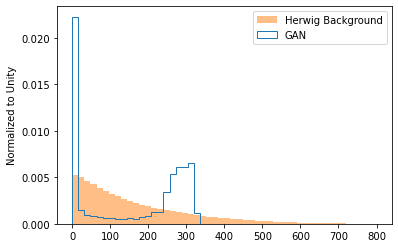

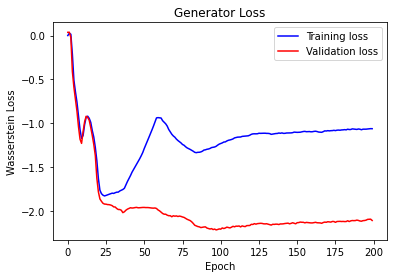

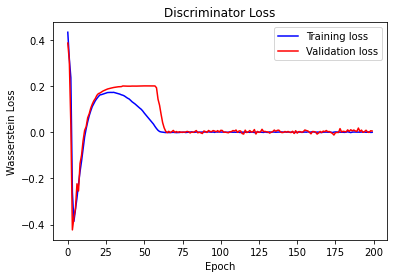

 21%|████████████████▏                                                            | 210/1000 [49:25<3:02:18, 13.85s/it]


Epoch 210:

Generator training loss: -1.0767500302830681
Discriminator training loss: -0.000839502802909671

Generator validation loss: -2.116268636750393
Discriminator validation loss: -0.004533021773329624


 22%|████████████████▉                                                            | 220/1000 [51:44<2:59:49, 13.83s/it]


Epoch 220:

Generator training loss: -1.0991944384053756
Discriminator training loss: -0.0008428389830829683

Generator validation loss: -2.134850718935982
Discriminator validation loss: 0.00489111536241625


 23%|█████████████████▋                                                           | 230/1000 [54:02<2:58:02, 13.87s/it]


Epoch 230:

Generator training loss: -1.1950016347436958
Discriminator training loss: -0.002081839529019106

Generator validation loss: -2.240338261010217
Discriminator validation loss: 0.009184670108313229


 24%|██████████████████▍                                                          | 240/1000 [56:22<2:56:34, 13.94s/it]


Epoch 240:

Generator training loss: -1.2339766276338713
Discriminator training loss: -0.0010522257339562698

Generator validation loss: -2.280966788041787
Discriminator validation loss: 0.014538264779954171


 25%|███████████████████▎                                                         | 250/1000 [58:42<2:56:28, 14.12s/it]


Epoch 250:

Generator training loss: -1.228251760123206
Discriminator training loss: -0.0010540501453875262

Generator validation loss: -2.2636081410236044
Discriminator validation loss: -0.01351958560446262


 26%|███████████████████▌                                                       | 260/1000 [1:01:06<2:56:20, 14.30s/it]


Epoch 260:

Generator training loss: -1.2269092710291754
Discriminator training loss: -0.0016600797329682608

Generator validation loss: -2.2584880355928765
Discriminator validation loss: 0.001732546433216709


 27%|████████████████████▎                                                      | 270/1000 [1:03:27<2:51:00, 14.05s/it]


Epoch 270:

Generator training loss: -1.2409827569143368
Discriminator training loss: -0.0008953222659587621

Generator validation loss: -2.277376856960234
Discriminator validation loss: -0.012906949669428047


 28%|█████████████████████                                                      | 280/1000 [1:05:48<2:49:51, 14.16s/it]


Epoch 280:

Generator training loss: -1.2341002121649154
Discriminator training loss: 0.0003796978123741138

Generator validation loss: -2.267903568314724
Discriminator validation loss: 0.003154753322797049


 29%|█████████████████████▊                                                     | 290/1000 [1:08:09<2:44:59, 13.94s/it]


Epoch 290:

Generator training loss: -1.2359297314628226
Discriminator training loss: 0.00047696021445050376

Generator validation loss: -2.289224319770688
Discriminator validation loss: 0.0024029338502393823


 30%|██████████████████████▍                                                    | 299/1000 [1:10:15<2:42:22, 13.90s/it]


Epoch 300:

Generator training loss: -1.2498852620359326
Discriminator training loss: -0.0008115930107297807

Generator validation loss: -2.280708492779341
Discriminator validation loss: -0.00188319254871725

Epoch 300:


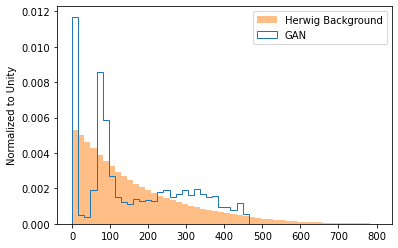

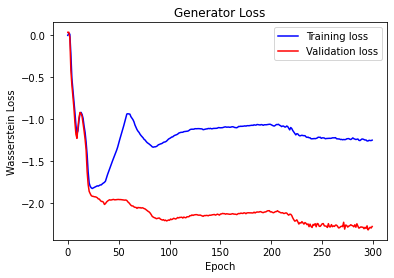

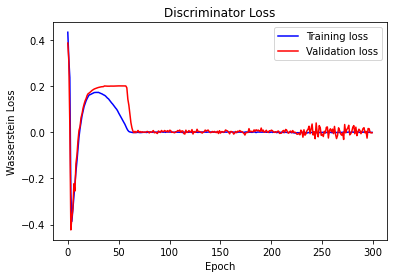

 31%|███████████████████████▎                                                   | 310/1000 [1:12:49<2:40:12, 13.93s/it]


Epoch 310:

Generator training loss: -1.2591618605650188
Discriminator training loss: -0.0006811612148394587

Generator validation loss: -2.318547833161276
Discriminator validation loss: 0.014102999836499383


 32%|████████████████████████                                                   | 320/1000 [1:15:08<2:38:08, 13.95s/it]


Epoch 320:

Generator training loss: -1.2702668739146874
Discriminator training loss: 0.00031230839959675284

Generator validation loss: -2.318966312486617
Discriminator validation loss: 0.002937867295437828


 33%|████████████████████████▊                                                  | 330/1000 [1:17:30<2:38:01, 14.15s/it]


Epoch 330:

Generator training loss: -1.2994409496666954
Discriminator training loss: -0.0004047910183559355

Generator validation loss: -2.3628831965024353
Discriminator validation loss: 0.014980188769395233


 34%|█████████████████████████▌                                                 | 340/1000 [1:19:51<2:35:22, 14.12s/it]


Epoch 340:

Generator training loss: -1.3048906622688627
Discriminator training loss: 0.0002369521868642123

Generator validation loss: -2.3708498106628166
Discriminator validation loss: 0.017193025781975325


 35%|██████████████████████████▎                                                | 350/1000 [1:22:13<2:33:32, 14.17s/it]


Epoch 350:

Generator training loss: -1.336962829847805
Discriminator training loss: 0.0005289639550823556

Generator validation loss: -2.408902578666562
Discriminator validation loss: 0.011465585229013756


 36%|███████████████████████████                                                | 360/1000 [1:24:34<2:30:17, 14.09s/it]


Epoch 360:

Generator training loss: -1.368798650679041
Discriminator training loss: 0.001854416647731709

Generator validation loss: -2.4360385175611152
Discriminator validation loss: 0.029063139816929328


 37%|███████████████████████████▊                                               | 370/1000 [1:26:54<2:27:01, 14.00s/it]


Epoch 370:

Generator training loss: -1.4061906441964738
Discriminator training loss: -0.0005566196355051387

Generator validation loss: -2.4430121339735438
Discriminator validation loss: -0.02430350614757445


 38%|████████████████████████████▌                                              | 380/1000 [1:29:14<2:26:13, 14.15s/it]


Epoch 380:

Generator training loss: -1.4570219953203463
Discriminator training loss: -0.0003267839219100847

Generator validation loss: -2.512482733022971
Discriminator validation loss: -0.0019260484238329213


 39%|█████████████████████████████▎                                             | 390/1000 [1:31:38<2:24:27, 14.21s/it]


Epoch 390:

Generator training loss: -1.492584692650154
Discriminator training loss: 0.0011577630141577264

Generator validation loss: -2.551919204289796
Discriminator validation loss: 0.015247003791985469


 40%|█████████████████████████████▉                                             | 399/1000 [1:33:43<2:20:23, 14.02s/it]


Epoch 400:

Generator training loss: -1.536313994986112
Discriminator training loss: 0.0006846259572595527

Generator validation loss: -2.5912470563513335
Discriminator validation loss: -0.0010257431961496772

Epoch 400:


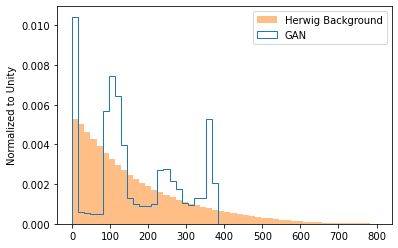

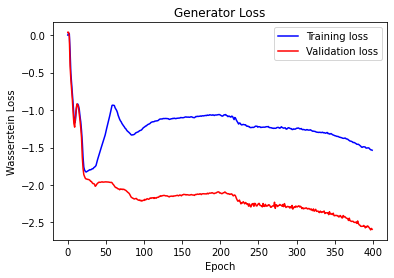

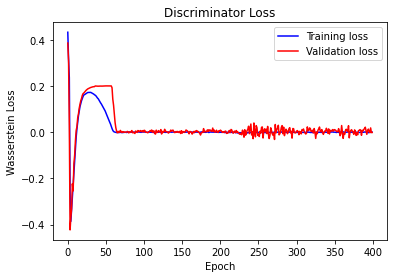

 41%|██████████████████████████████▋                                            | 410/1000 [1:36:20<2:20:38, 14.30s/it]


Epoch 410:

Generator training loss: -1.558302996588535
Discriminator training loss: 0.0007573268185485768

Generator validation loss: -2.616586329507046
Discriminator validation loss: 0.027684742798570725


 42%|███████████████████████████████▌                                           | 420/1000 [1:38:40<2:13:25, 13.80s/it]


Epoch 420:

Generator training loss: -1.57342077702121
Discriminator training loss: 0.0006556320399889796

Generator validation loss: -2.6356168516346665
Discriminator validation loss: 0.00712754497983012


 43%|████████████████████████████████▎                                          | 430/1000 [1:41:00<2:13:57, 14.10s/it]


Epoch 430:

Generator training loss: -1.5852701074438669
Discriminator training loss: 0.002174732176817351

Generator validation loss: -2.6153384779320388
Discriminator validation loss: -0.019764502139043513


 44%|█████████████████████████████████                                          | 440/1000 [1:43:24<2:14:08, 14.37s/it]


Epoch 440:

Generator training loss: -1.6904998164359337
Discriminator training loss: -0.0005463659477705147

Generator validation loss: -2.722688997378115
Discriminator validation loss: 0.009383699016146491


 45%|█████████████████████████████████▊                                         | 450/1000 [1:45:46<2:10:38, 14.25s/it]


Epoch 450:

Generator training loss: -1.70167858776499
Discriminator training loss: 0.0006180629192823175

Generator validation loss: -2.7565917714697417
Discriminator validation loss: 0.0050808001720188106


 46%|██████████████████████████████████▌                                        | 460/1000 [1:48:06<2:05:15, 13.92s/it]


Epoch 460:

Generator training loss: -1.7288635457799735
Discriminator training loss: 0.0003218578906063292

Generator validation loss: -2.7909347796049273
Discriminator validation loss: 0.01246559082198369


 47%|███████████████████████████████████▎                                       | 470/1000 [1:50:26<2:05:59, 14.26s/it]


Epoch 470:

Generator training loss: -1.7621108143707442
Discriminator training loss: 6.869234602476591e-05

Generator validation loss: -2.814587993699996
Discriminator validation loss: 0.011326357558036612


 48%|████████████████████████████████████                                       | 480/1000 [1:52:46<1:59:56, 13.84s/it]


Epoch 480:

Generator training loss: -1.785894620939682
Discriminator training loss: -0.0006747642388668556

Generator validation loss: -2.8357632961429533
Discriminator validation loss: -0.009407751727849245


 49%|████████████████████████████████████▊                                      | 490/1000 [1:55:04<1:56:53, 13.75s/it]


Epoch 490:

Generator training loss: -1.9146010478337605
Discriminator training loss: 0.00013110429240814335

Generator validation loss: -2.9803261424674363
Discriminator validation loss: -0.004479614875413435


 50%|█████████████████████████████████████▍                                     | 499/1000 [1:57:09<1:54:55, 13.76s/it]


Epoch 500:

Generator training loss: -1.9589646813647994
Discriminator training loss: 0.0002205525869071036

Generator validation loss: -3.0077991036118052
Discriminator validation loss: 0.014299093115980332

Epoch 500:


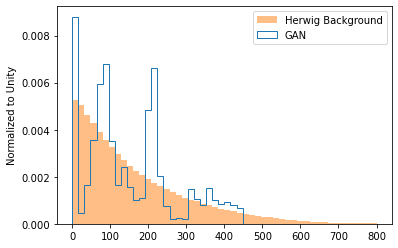

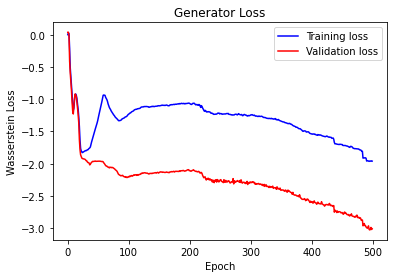

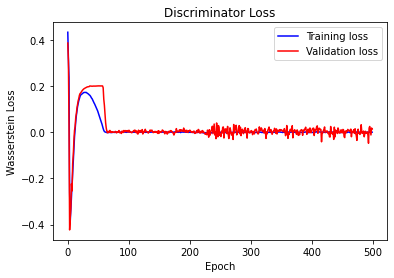

 51%|██████████████████████████████████████▎                                    | 510/1000 [1:59:44<1:54:32, 14.03s/it]


Epoch 510:

Generator training loss: -2.02320820907426
Discriminator training loss: 0.0005035253981817921

Generator validation loss: -3.0776911192252987
Discriminator validation loss: 0.028357556921842157


 52%|███████████████████████████████████████                                    | 520/1000 [2:02:08<1:56:35, 14.57s/it]


Epoch 520:

Generator training loss: -2.133717877617299
Discriminator training loss: -0.0005806710047161816

Generator validation loss: -3.136207908880515
Discriminator validation loss: 0.0020285899293815074


 53%|███████████████████████████████████████▊                                   | 530/1000 [2:04:32<1:52:40, 14.38s/it]


Epoch 530:

Generator training loss: -2.1441379479371783
Discriminator training loss: -0.00029050739057574554

Generator validation loss: -3.1565734304365565
Discriminator validation loss: -0.0041738793536706745


 54%|████████████████████████████████████████▌                                  | 540/1000 [2:06:56<1:50:13, 14.38s/it]


Epoch 540:

Generator training loss: -2.15412759520317
Discriminator training loss: 0.00011905031933565625

Generator validation loss: -3.170917380051535
Discriminator validation loss: -0.002434319281448671


 55%|█████████████████████████████████████████▎                                 | 550/1000 [2:09:18<1:46:27, 14.19s/it]


Epoch 550:

Generator training loss: -2.238661322437349
Discriminator training loss: 0.0023480005154096397

Generator validation loss: -3.265776843321128
Discriminator validation loss: 0.01955674905100929


 56%|██████████████████████████████████████████                                 | 560/1000 [2:11:40<1:44:52, 14.30s/it]


Epoch 560:

Generator training loss: -2.2823679577457447
Discriminator training loss: 0.0012168446884901186

Generator validation loss: -3.3004810126101383
Discriminator validation loss: 0.012717804062079074


 57%|██████████████████████████████████████████▋                                | 570/1000 [2:14:03<1:41:55, 14.22s/it]


Epoch 570:

Generator training loss: -2.3546589339365727
Discriminator training loss: 0.0008039323998116722

Generator validation loss: -3.3300169745429615
Discriminator validation loss: 0.0007434086676424114


 58%|███████████████████████████████████████████▌                               | 580/1000 [2:16:25<1:38:48, 14.11s/it]


Epoch 580:

Generator training loss: -2.4072446836148456
Discriminator training loss: -0.0007997280123352221

Generator validation loss: -3.39092453972238
Discriminator validation loss: -0.008923734611121066


 59%|████████████████████████████████████████████▎                              | 590/1000 [2:18:45<1:36:32, 14.13s/it]


Epoch 590:

Generator training loss: -2.3813969717651116
Discriminator training loss: -0.0013972186482965672

Generator validation loss: -3.400083387484316
Discriminator validation loss: 0.019312718558004965


 60%|████████████████████████████████████████████▉                              | 599/1000 [2:20:50<1:32:55, 13.90s/it]


Epoch 600:

Generator training loss: -2.4776462283942218
Discriminator training loss: 0.0008363677815241864

Generator validation loss: -3.4727096108139537
Discriminator validation loss: -0.0033541333925582043

Epoch 600:


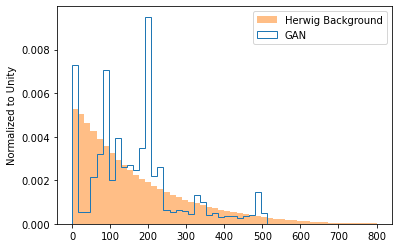

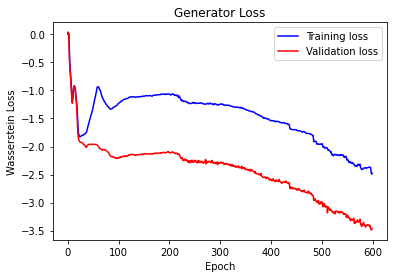

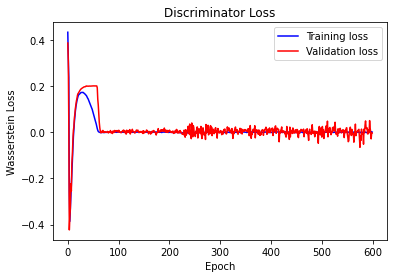

 61%|█████████████████████████████████████████████▊                             | 610/1000 [2:23:23<1:30:12, 13.88s/it]


Epoch 610:

Generator training loss: -2.4267906445623098
Discriminator training loss: -0.0012494204921326133

Generator validation loss: -3.4834031316100575
Discriminator validation loss: 0.011090252529371713


 62%|██████████████████████████████████████████████▎                            | 618/1000 [2:25:13<1:28:07, 13.84s/it]

In [ ]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []
train(train_dataset, test_dataset, 1000, N_CRITIC)

## Results
Train for 4 features works pretty well and took 2:20 hrs for 1000 epos with a 1080

In [ ]:
z